In [7]:
# Packages/libraries needed

import requests
import pandas as pd
import numpy as np
import math
from datetime import date, timedelta, datetime
import matplotlib.pyplot as plt
from statistics import mean
import plotly.graph_objects as go 
import plotly.express as px
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from functools import lru_cache

## Weather data

In [25]:
#Heatmap to check correlation between weather variables
#weather_data denotes the dataframe containing weather data

weather_data = pd.read_csv('ThesisData/H1_HIweather.csv')
corr = weather_data.corr()
corr.style.background_gradient(cmap='coolwarm')

,HCC,LCC,MCC,Pressure,RH,SDR,Temp,TCC,TP,WD,WS
HCC,1.000000,-0.034781,0.388829,-0.224987,-0.004295,-0.019869,0.113012,0.615426,0.045642,-0.049760,0.027560
LCC,-0.034781,1.000000,0.224107,-0.138878,0.264724,-0.276696,-0.228661,0.578489,0.228837,0.348916,0.434019
MCC,0.388829,0.224107,1.000000,-0.384583,0.085627,-0.157237,-0.029288,0.534268,0.273644,0.010638,0.240130
Pressure,-0.224987,-0.138878,-0.384583,1.000000,0.130587,-0.004354,-0.255955,-0.272494,-0.246848,-0.072072,-0.415606
RH,-0.004295,0.264724,0.085627,0.130587,1.000000,-0.677680,-0.600573,0.175174,0.120159,0.087387,-0.137661
SDR,-0.019869,-0.276696,-0.157237,-0.004354,-0.677680,1.000000,0.552253,-0.199346,-0.069682,-0.012288,0.006659
Temp,0.113012,-0.228661,-0.029288,-0.255955,-0.600573,0.552253,1.000000,-0.056114,-0.026458,0.041588,-0.116580
TCC,0.615426,0.578489,0.534268,-0.272494,0.175174,-0.199346,-0.056114,1.000000,0.162176,0.198270,0.280346
TP,0.045642,0.228837,0.273644,-0.246848,0.120159,-0.069682,-0.026458,0.162176,1.000000,0.105325,0.268885
WD,-0.049760,0.348916,0.010638,-0.072072,0.087387,-0.012288,0.041588,0.198270,0.105325,1.000000,0.172817


## Household PV Data

In [2]:
old = pd.read_csv('ThesisData/H1_old.csv')
old = old.set_index('to_timestamp', drop=True)
old.columns = old.columns.str[-30:]
    
new = pd.read_csv('ThesisData/H1_new.csv')
new = new.set_index('to_timestamp', drop=True)
new.index = [str(x)[:-6] for x in new.index]
new.index = pd.to_datetime(new.index)
    
HHData = old.append(new)
HHData.index = pd.to_datetime(HHData.index)

In [3]:
pv_data = HHData.copy()

In [5]:
#pv_data denotes the dataframe containing household pv data

#get 6 months of data from January to June 2022
pv_data.index = pd.to_datetime(pv_data.index)
pv_data = pv_data[pv_data.index <= '2022-07-01 00:00:00']

[18 19 20 21 22 23  0  1  2  3  4  5 17  6 12 16  7]
[ 2  3 20 17 19 23  0  7 21  1  6 22  4  5 16 18  8 15 14]


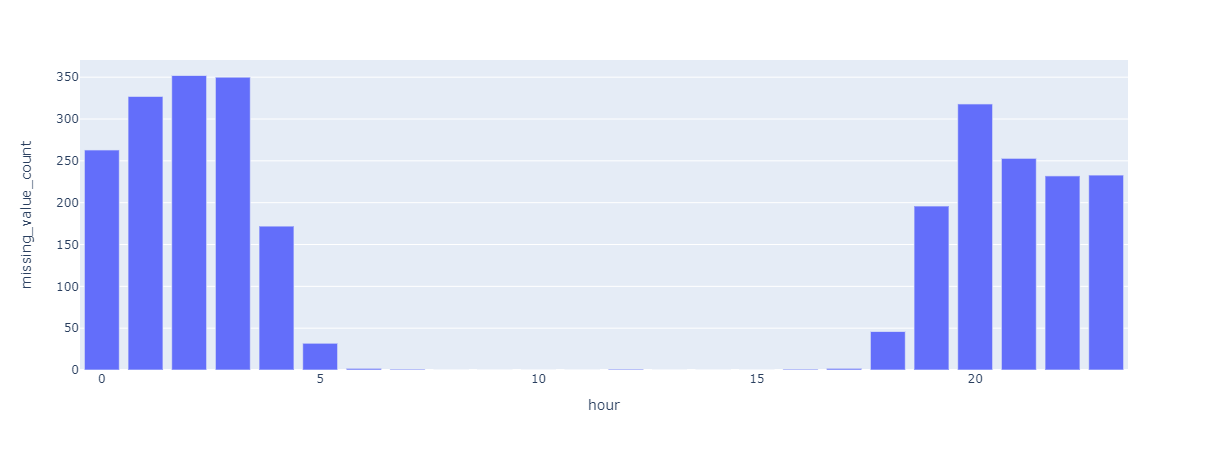

In [24]:
pv_data['datetime'] = pv_data.index.copy()
pv_data['hour'] = pv_data['datetime'].dt.hour

#check distribution of Nan values by the hour 
missing = pv_data[pv_data['negative_active_energy_flow_wh'].isnull()]
print(missing['hour'].unique())

#check distribution of negative values by the hour 
neg = pv_data[ pv_data['negative_active_energy_flow_wh']<0]
print(neg['hour'].unique())

#plot distribution of Nan values by the hour (same code can be altered for negative entries)
miss_count = pd.DataFrame(columns=['hour', 'missing_value_count'])
hour = []
mc = []
for i in range(24):
    count = len(missing[missing['hour']==i])
    hour.append(i)
    mc.append(count)
miss_count['hour'] = hour
miss_count['missing_value_count'] = mc
    
fig = px.bar(miss_count, x='hour', y='missing_value_count')
fig.show()

In [8]:
#Add binary indicator column

def time_convert(str1):
    if (str1[-2:] == "AM"):
        return str(0) + str1[:-2]
    elif (str1[-2:] == "PM") & (int(str1[:1]) >=2):
        return str(int(str1[:1]) + 12) + str1[1:8]
    else:
        return str(int(str1[:2]) + 12) + str1[2:8]
    
@lru_cache(maxsize = 18000) 
def get_sunrise_sunset(latitude, longitude, date):
    
    url = f"https://api.sunrise-sunset.org/json?lat={latitude}&lng={longitude}&date={date.date()}"
    resp = requests.get(url).json()
    sunrise = pd.to_datetime(time_convert(resp['results']['sunrise']))
    sunset = pd.to_datetime(time_convert(resp['results']['sunset']))
    
    return sunrise, sunset   

def add_BIcolumn(pv_data):
    
    df = pv_data.copy()
    latitude = 50.93
    longitude = 5.33
    df['LDI'] = 0
    start = df.index.min().date()
    end = df.index.max().date()
#     print(start, end)
    
    for date1 in pd.date_range(start, end, freq='D'):
        sunrise, sunset = get_sunrise_sunset(latitude, longitude, date1)
        range_start = pd.to_datetime(datetime.combine(date1, sunrise.time()))
        range_end = pd.to_datetime(datetime.combine(date1, sunset.time()))
        df.loc[(df.index > range_start) & (df.index < range_end), 'LDI'] = 1
        
    return df

In [9]:
# Prepares the PV data for tests by adding binary indicator column and replaces missing and negative values

def prep_pv_data(pv_data):    
    
    hh_data = pv_data.copy()
    hh_data = add_BIcolumn(hh_data)
    hh_data['datetime'] = hh_data.index.copy()
    hh_data['month'] =  hh_data['datetime'].dt.month
    hh_data['hour'] =  hh_data['datetime'].dt.hour
    hh_data =  hh_data.drop_duplicates('datetime', keep='last')
    
    for i in range(len(hh_data)):
        if hh_data['LDI'][i] == 0:
            hh_data['negative_active_energy_flow_wh'][i] = 0 
    
    missing = hh_data[hh_data['negative_active_energy_flow_wh'].isnull()]
    for i in range(len(missing)):
        target_month = missing.index[i].month
        target_hour = missing.index[i].hour
        temp_hh = hh_data[~hh_data.index.isin(missing.index)]
        temp = temp_hh[(temp_hh['month']==target_month)& (temp_hh['hour']==target_hour)]
        missing['negative_active_energy_flow_wh'][i] = temp['negative_active_energy_flow_wh'].mean()
    
    hh_data.loc[hh_data.index.isin(missing.index) , 'negative_active_energy_flow_wh'] = missing['negative_active_energy_flow_wh']
    
    neg = hh_data[hh_data['negative_active_energy_flow_wh']<0]
    for i in range(len(neg)):
        target_month1 = neg.index[i].month
        target_hour1 = neg.index[i].hour         
        temp_hh1 = hh_data[~hh_data.index.isin(neg.index)]
        temp1 = temp_hh1[(temp_hh1['month']==target_month1)& ( temp_hh1['hour']==target_hour1)]
        neg['negative_active_energy_flow_wh'][i] = temp1['negative_active_energy_flow_wh'].mean()

    hh_data.loc[hh_data.index.isin(neg.index) , 'negative_active_energy_flow_wh'] = neg['negative_active_energy_flow_wh']
    
    hh_data = hh_data.drop(['datetime', 'hour', 'month', 'LDI'], axis =1)
    hh_data = hh_data.fillna(0)
    hh_data = hh_data.clip(0)
    hh_data = hh_data.round(2)
        
    return hh_data  

In [ ]:
pv_data1 = prep_pv_data(pv_data)
display(pv_data1)

In [11]:
#Perform ADF test on processed pv data

result = adfuller(pv_data1['negative_active_energy_flow_wh'], autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -22.485913
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


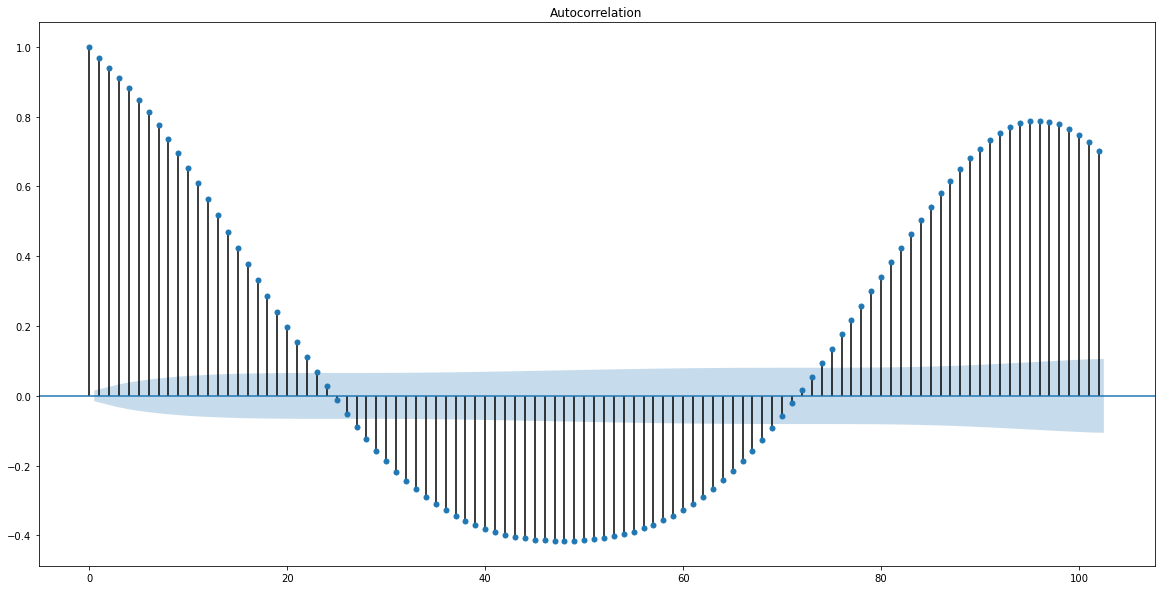

In [18]:
fig, ax = plt.subplots(figsize=(20, 10))

#Autocorrelation plot with 102 previous timestamps on processed data to decide on the lagged variables
plot_102 = plot_acf(pv_data1['negative_active_energy_flow_wh'], lags = 102, ax=ax)

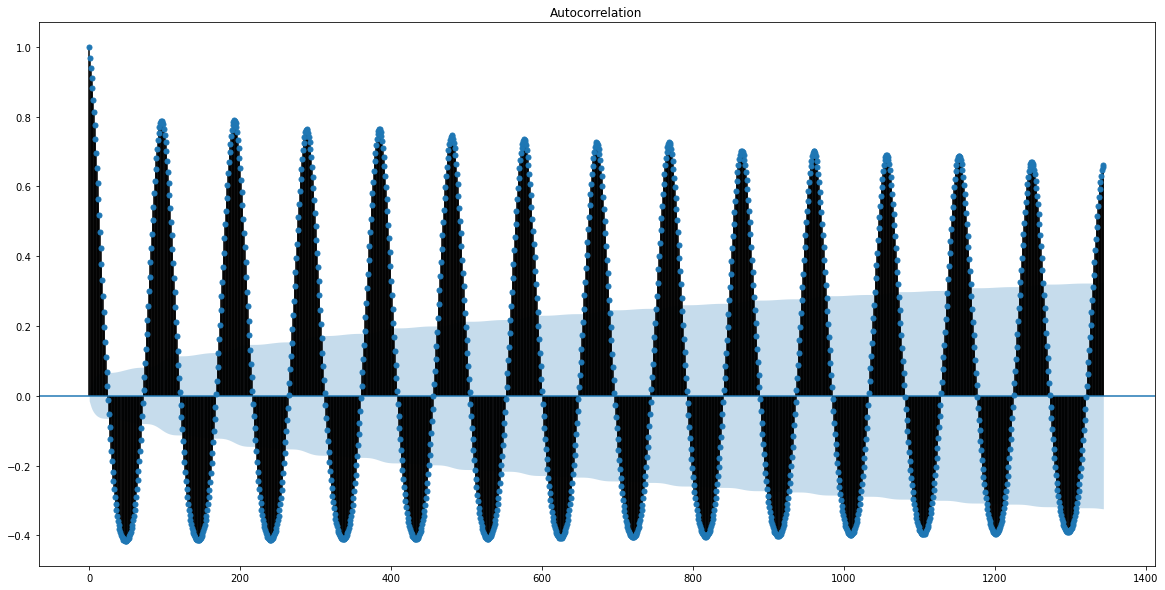

In [21]:
#Autocorrelation plot with timestamps from the past 2 weeks on processed data to decide on the lagged variables
fig, ax1 = plt.subplots(figsize=(20, 10))
plot_2w = plot_acf(pv_data1['negative_active_energy_flow_wh'], lags = 1344, ax=ax1)

In [ ]:
def add_lagged(df):
    
    df1=df.copy()    
    
    prev1 = df1['negative_active_energy_flow_wh'].shift(96, fill_value=0)
    prev2 = df1['negative_active_energy_flow_wh'].shift(192, fill_value=0)
    prev3 = df1['negative_active_energy_flow_wh'].shift(288, fill_value=0)
#     prev4 = df1['negative_active_energy_flow_wh'].shift(384, fill_value=0)
    
    prev_mean = df1['negative_active_energy_flow_wh'].rolling(3).mean()
    
    df1.insert(loc=0, column='prev1', value= prev1)
    df1.insert(loc=1, column='prev2', value= prev2)
    df1.insert(loc=2, column='prev3', value= prev3)
#     df1.insert(loc=3, column='prev4', value= prev4)

    df1.insert(loc=3, column = 'prev1_mean', value = prev_mean.shift(96, fill_value=0))  
    df1.insert(loc=4, column = 'prev2_mean', value = prev_mean.shift(192, fill_value=0))
    df1.insert(loc=5, column = 'prev3_mean', value = prev_mean.shift(288, fill_value=0))
    
    df2 = pd.DataFrame(df1[288:])

    return df2

In [ ]:
#Plot unprocessed household data without negative entries

pv_data2 = pv_data.clip(0)
fig = go.Figure()
fig.add_trace(go.Scatter(x=pv_data2.index, y=pv_data2['negative_active_energy_flow_wh'],
                    name='Energy_flow',
                    line = dict(color='goldenrod', width=4)))
fig.show()